Starte Skript: LGBM-Klassifikations-Pipeline

 TEIL 1 & 2: DATEN LADEN UND FEATURE ENGINEERING
1.1 Lade statische Attribute und filtere relevante Stationen...
--> 264 relevante Stationen für die Analyse gefunden.

1.2 Lade dynamische Zeitreihen für die ausgewählten Stationen...
--> Zeitreihen erfolgreich geladen.

1.3 Berechne monatliche Features aus jährlichen Werten...

1.4 Führe SGI-Berechnung und Feature-Engineering pro Station durch...


SGI-Berechnung & Dekomposition: 100%|██████████| 264/264 [00:50<00:00,  5.25it/s]



1.5 Führe dynamische und statische Features zusammen...

1.6 Erstelle zeitversetzte (Lag) Features und Zielvariable...

1.7 Wandle Zielvariable in Klassen um und kodiere kategorische Features...

1.7.1 Kodierung der kategorischen Features...
--> Folgende kategorische Spalten werden kodiert: ['main_landuse', 'month_num']
    - Kodiere 'main_landuse'...
    - Kodiere 'month_num'...

1.8 Bereinige finale Datensätze...

[SUCCESS] Teil 1 & 2 abgeschlossen.

 TEIL 3: MODELLTRAINING & EVALUATION
--> Erstelle zeitbasierten 80/10/10 Split:
      - Trainingsdaten: Jahre < 2008 (80%)
      - Validierungsdaten: Jahre >= 2008 und < 2014 (10%)
      - Testdaten: Jahre >= 2014 (10%)

Größe der Datensätze:
      - Training:   129036 Zeilen
      - Validation: 19008 Zeilen
      - Test:       22176 Zeilen

--------------------------------------------------------------------------------
--> Folgende 45 Features werden für das Modell verwendet:
-----------------------------------------------------------

X does not have valid feature names, but LGBMClassifier was fitted with feature namesX does not have valid feature names, but LGBMClassifier was fitted with feature names


Klassifikations-Metriken:
               precision    recall  f1-score   support

       Normal       0.93      0.98      0.95     16738
Mild_Moderate       0.54      0.38      0.45      1736
       Severe       0.46      0.19      0.26       439
      Extreme       0.50      0.05      0.10        95

     accuracy                           0.90     19008
    macro avg       0.61      0.40      0.44     19008
 weighted avg       0.88      0.90      0.89     19008



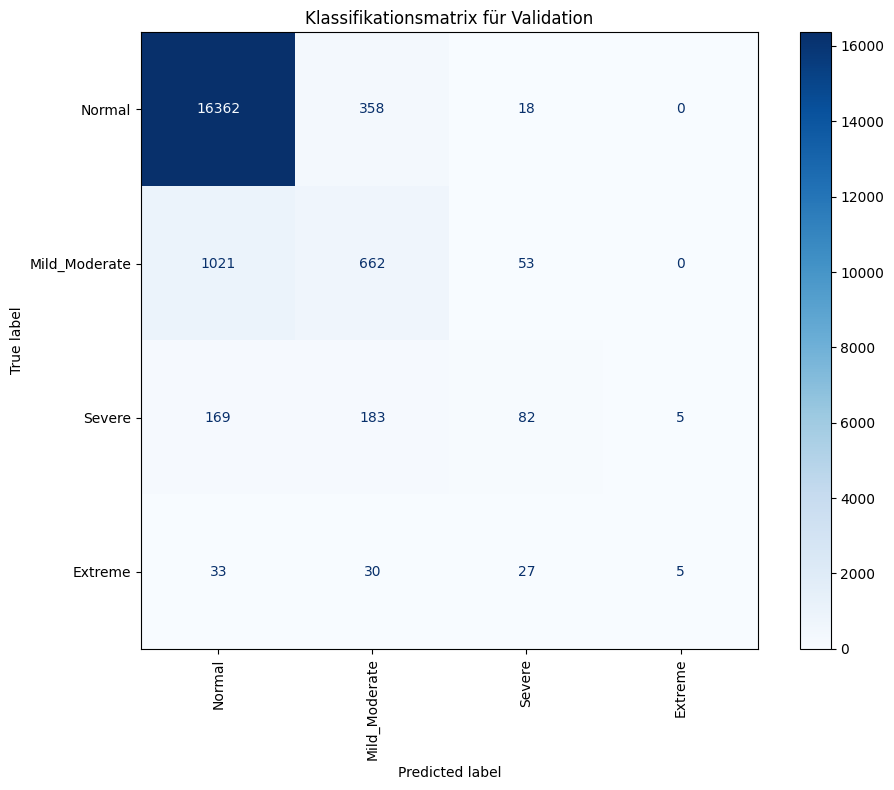


--------------------------------------------------------------------------------
 EVALUATION AUF TEST-DATEN
--------------------------------------------------------------------------------


X does not have valid feature names, but LGBMClassifier was fitted with feature namesX does not have valid feature names, but LGBMClassifier was fitted with feature names


Klassifikations-Metriken:
               precision    recall  f1-score   support

       Normal       0.84      0.93      0.88     13792
Mild_Moderate       0.55      0.52      0.53      4848
       Severe       0.55      0.38      0.45      2501
      Extreme       0.65      0.37      0.47      1035

     accuracy                           0.75     22176
    macro avg       0.65      0.55      0.58     22176
 weighted avg       0.73      0.75      0.74     22176



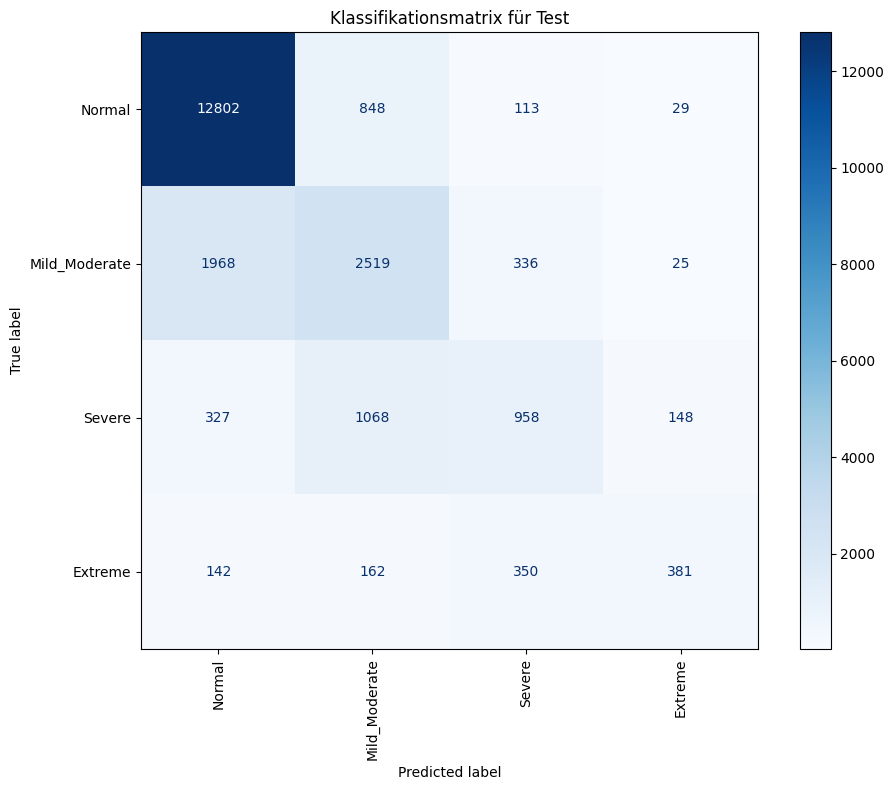


 TEIL 3C: MODELLINTERPRETATION

--> LightGBM Feature Importance (nach 'gain'):
                          feature  importance
5                       sgi_trend        5278
11            sgi_seasonal_lag_6M        4076
18               sgi_trend_lag_3M        3622
43               sgi_resid_lag_6M        2919
40         ground_elevation_m_asl        2637
35                      sgi_resid        2636
34               sgi_trend_lag_6M        2469
21          precipitation_monthly        2439
24               sgi_resid_lag_1M        2332
10              sgi_resid_lag_12M        2309
30               sgi_label_lag_6M        2299
20              sgi_trend_lag_12M        2276
25            sgi_seasonal_lag_3M        2272
27  withdrawal_industrial_monthly        2265
32               sgi_resid_lag_3M        2255
6     withdrawal_domestic_monthly        2254
0         air_temperature_monthly        2200
19                   ndvi_monthly        2173
26                   sgi_seasonal        2129


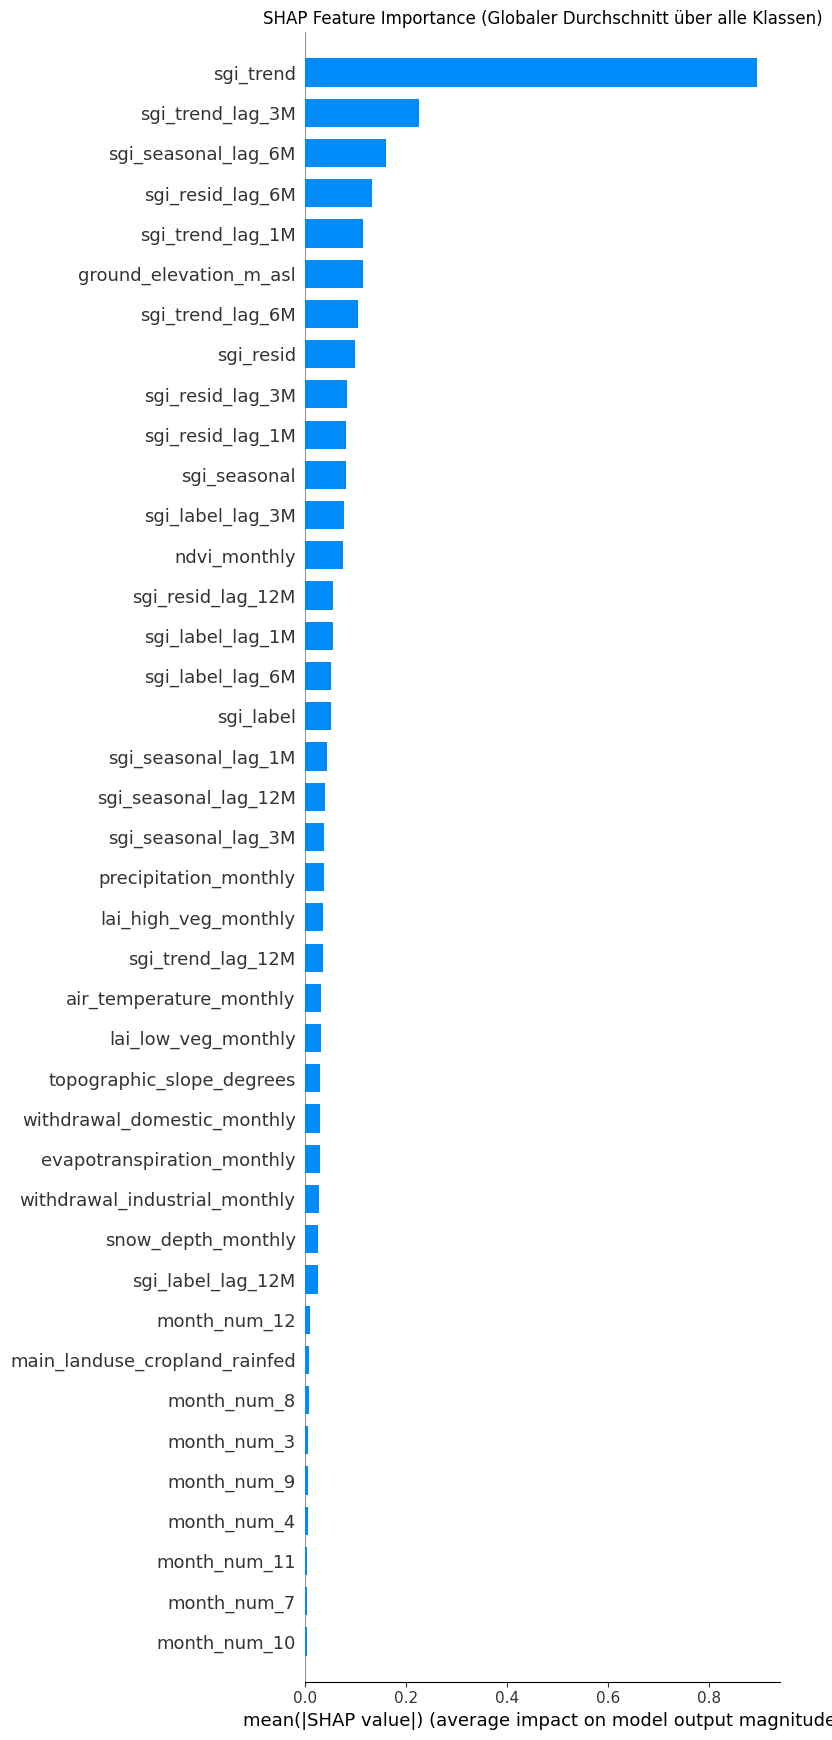


--> Erstelle SHAP Beeswarm Plots (Detailansicht) für jede Klasse...
    - Erstelle Beeswarm Plot für Klasse: 'Normal' (Index 0)


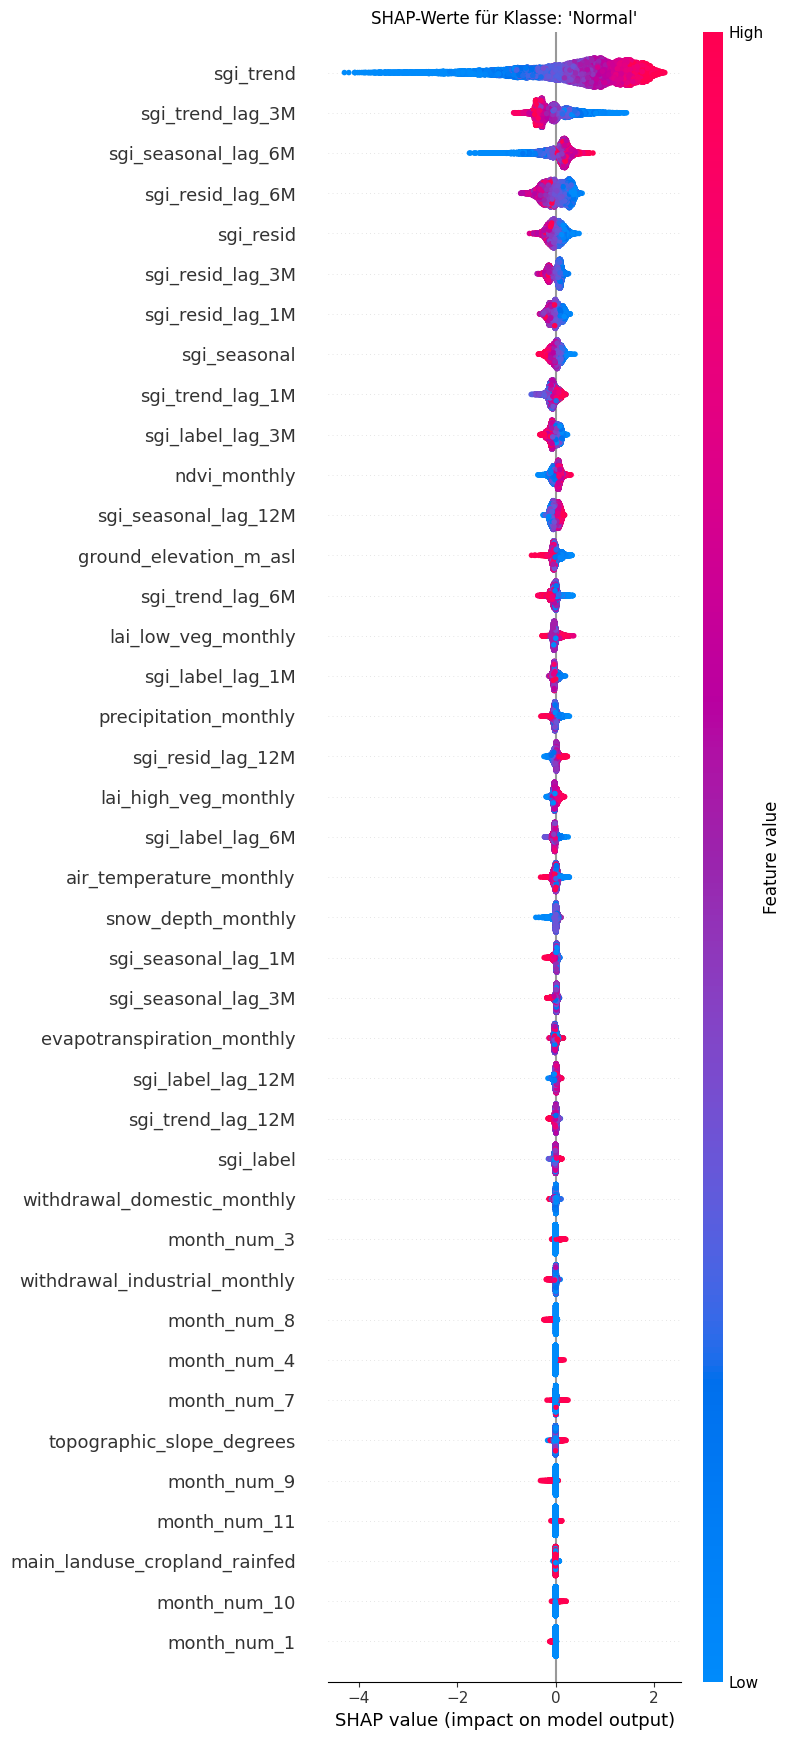

    - Erstelle Beeswarm Plot für Klasse: 'Mild_Moderate' (Index 1)


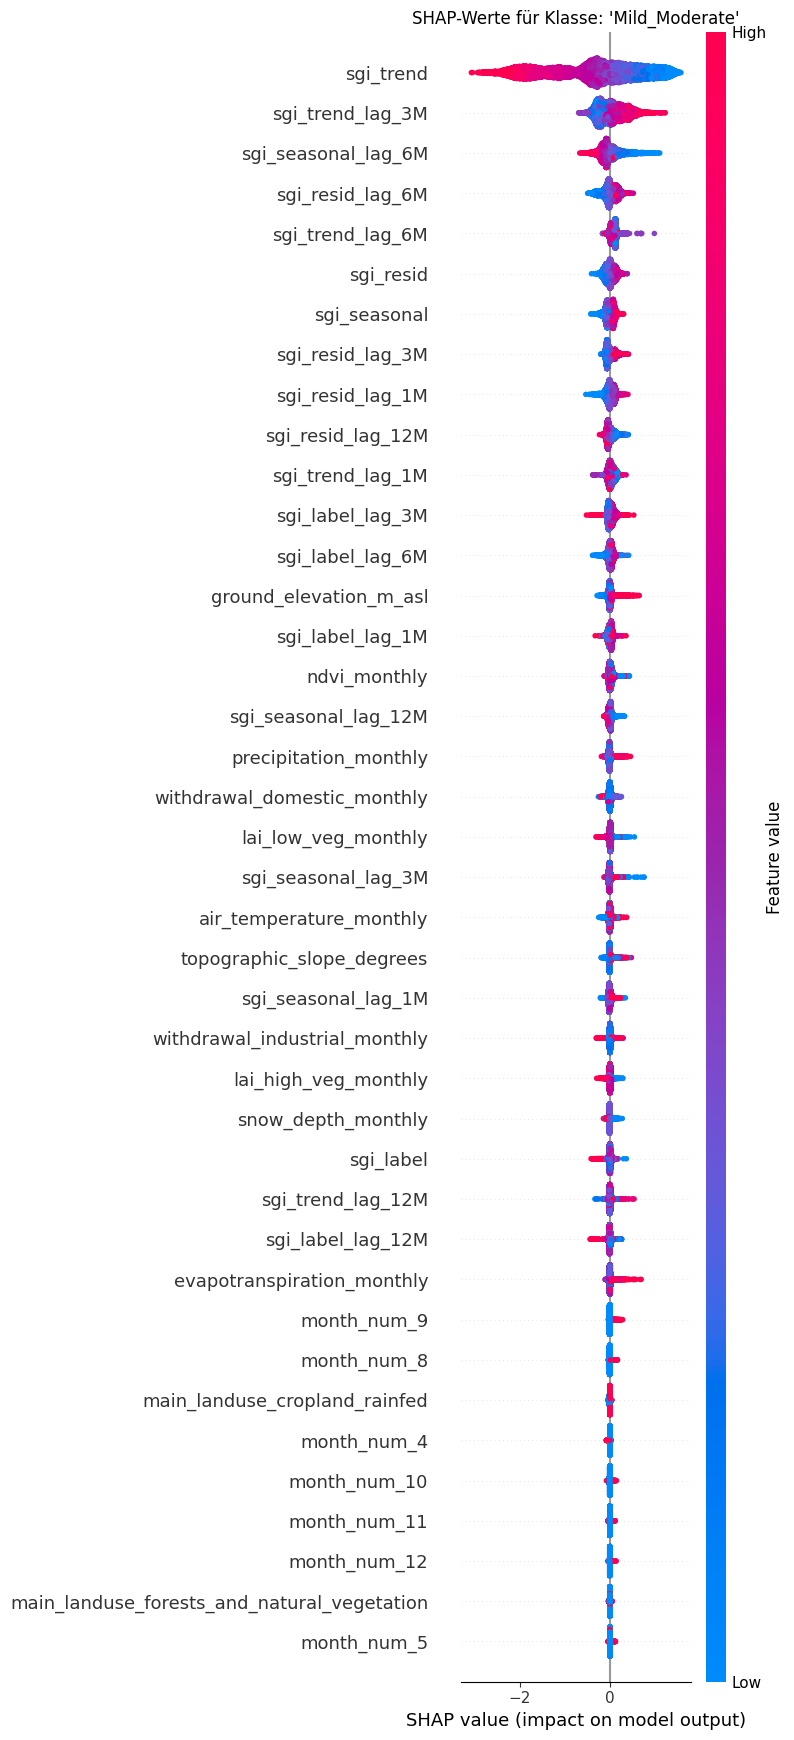

    - Erstelle Beeswarm Plot für Klasse: 'Severe' (Index 2)


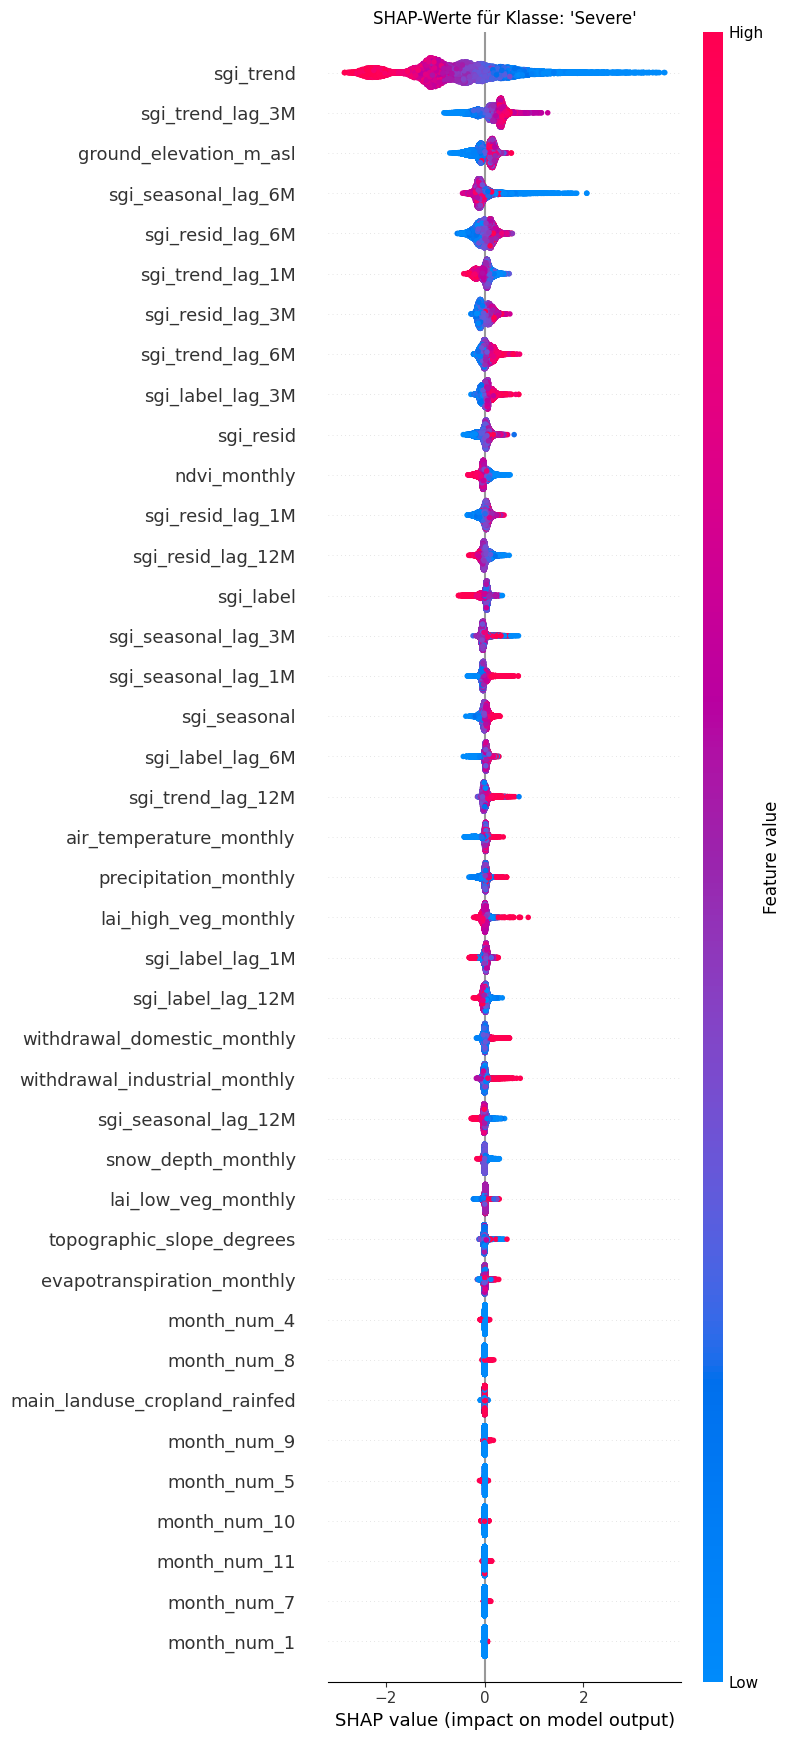

    - Erstelle Beeswarm Plot für Klasse: 'Extreme' (Index 3)


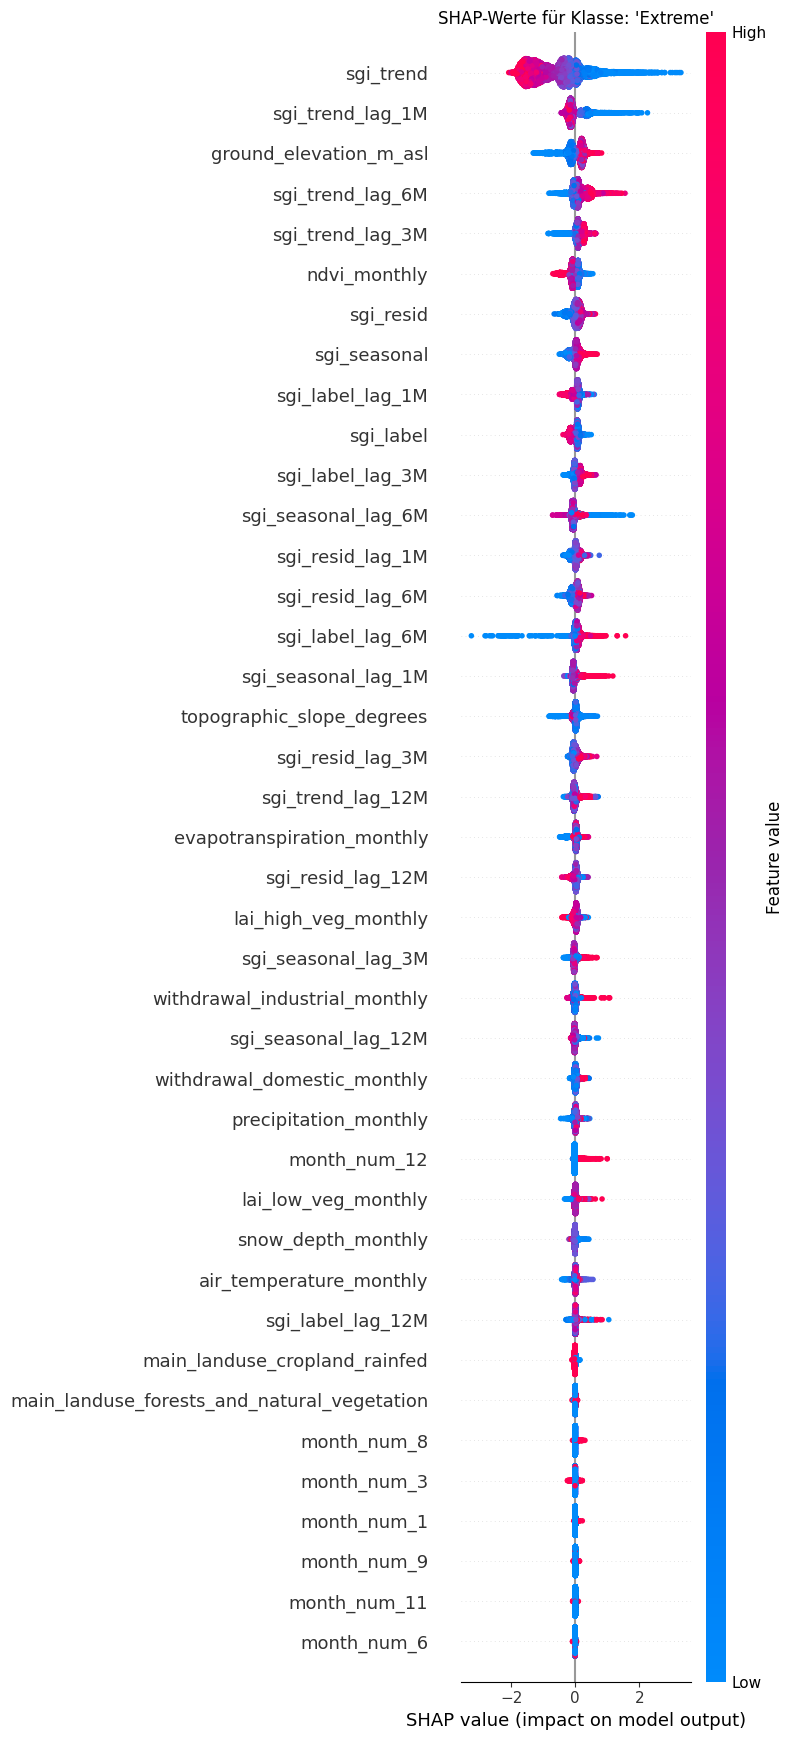


[SUCCESS] Teil 3 abgeschlossen.

 TEIL 4: SPEICHERN DER ERGEBNISSE
--> Testdaten mit Vorhersagen und Wahrscheinlichkeiten gespeichert: test_data_final_classification.csv

Skript vollständig abgeschlossen.


In [ ]:
# --- TEIL 0: Bibliotheken importieren und Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import io

# Spezialisierte Bibliotheken
import pastas as ps                                      # Für hydrologische Zeitreihenanalyse, speziell für SGI-Berechnung
import pyarrow.dataset as ds                             # Zum effizienten Laden von Parquet-Dateien
import lightgbm as lgb                                   # Das LightGBM-Modell, ein Gradient Boosting Framework
import shap                                              # Für die Modell-Interpretation (SHapley Additive exPlanations)
from statsmodels.tsa.seasonal import STL                 # Für die saisonale Zerlegung von Zeitreihen

# Wichtige Werkzeuge von Scikit-learn
from sklearn.model_selection import GridSearchCV         # Zur automatischen Suche der besten Hyperparameter
from sklearn.pipeline import Pipeline                    # Um mehrere Verarbeitungsschritte zu einem Modell zu verketten
from sklearn.preprocessing import StandardScaler         # Zur Skalierung numerischer Features
from sklearn.impute import SimpleImputer                 # Zum Füllen von fehlenden Werten
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # Zur Evaluation des Modells

# Helfer-Bibliotheken
from tqdm import tqdm                                    # Für schöne Fortschrittsbalken bei langen Schleifen
from contextlib import redirect_stdout                   # Um störende Ausgaben von Bibliotheken zu unterdrücken

# --- Konfiguration ---
# Loglevel von 'pastas' reduzieren, um die Konsole sauber zu halten
ps.set_log_level("ERROR")
print("Starte Skript: LGBM-Klassifikations-Pipeline")

# --- Definition der Features ---
# Hier werden die Spaltennamen für verschiedene Feature-Typen zentral definiert.
STATIC_CATEGORICAL_FEATURES = ["main_landuse"]
STATIC_NUMERICAL_FEATURES = ["ground_elevation_m_asl", "topographic_slope_degrees"]
DYNAMIC_NUMERICAL_FEATURES_RAW = [
    "groundwater_level_m_asl", "precipitation_gpcc_mm_year-1",
    "potential_evapotranspiration_era5_mm_year-1", "air_temperature_°C", "snow_depth_m",
    "ndvi_ratio", "lai_low_vegetation_ratio", "lai_high_vegetation_ratio",
    "withdrawal_industrial_m3_year-1", "withdrawal_domestic_m3_year-1"
]

# --- TEIL 1 & 2: DATEN LADEN UND FEATURE ENGINEERING ---
print("\n" + "="*80); print(" TEIL 1 & 2: DATEN LADEN UND FEATURE ENGINEERING"); print("="*80)

# --- Schritt 1.1: Statische Attribute laden und filtern ---
print("1.1 Lade statische Attribute und filtere relevante Stationen...")
path_attributes = "C:/MLmitPython/ML-Python/Daten/grow_attributes.parquet"
path_timeseries = "C:/MLmitPython/ML-Python/Daten/grow_timeseries.parquet"
try:
    attr_df_full = pd.read_parquet(path_attributes)
except FileNotFoundError: raise

# Filtere die Attribute nach den gewünschten Kriterien (Tschechien, lange Zeitreihen, keine Lücken etc.)
attr_filtered_df = attr_df_full[(attr_df_full["country"] == "CZE") & (attr_df_full["length_years"] >= 30) & (attr_df_full["gap_fraction"] == 0.0) & (pd.to_datetime(attr_df_full["ending_date"]) >= pd.Timestamp("2023-12-01"))]
if attr_filtered_df.empty: raise ValueError("Keine passende Zeitreihe für CZ für ML gefunden.")
cz_ids_for_ml = attr_filtered_df["GROW_ID"].dropna().unique().tolist()
print(f"--> {len(cz_ids_for_ml)} relevante Stationen für die Analyse gefunden.")

# --- Schritt 1.2: Dynamische Zeitreihen laden ---
print("\n1.2 Lade dynamische Zeitreihen für die ausgewählten Stationen...")
dynamic_feature_columns_to_load = ["GROW_ID", "date"] + DYNAMIC_NUMERICAL_FEATURES_RAW
try:
    # PyArrow wird für schnelles, speichereffizientes Laden der großen Parquet-Datei verwendet
    timeseries_dataset_raw = ds.dataset(path_timeseries, format="parquet")
    available_columns_in_parquet = timeseries_dataset_raw.schema.names
    columns_to_actually_load = [col for col in dynamic_feature_columns_to_load if col in available_columns_in_parquet]
    timeseries_table_raw = timeseries_dataset_raw.to_table(filter=ds.field("GROW_ID").isin(cz_ids_for_ml), columns=columns_to_actually_load)
    raw_ts_df_full = timeseries_table_raw.to_pandas()
except FileNotFoundError: raise
raw_ts_df_full["date"] = pd.to_datetime(raw_ts_df_full["date"])
print("--> Zeitreihen erfolgreich geladen.")

# --- Schritt 1.3: Erste Feature-Anpassungen ---
print("\n1.3 Berechne monatliche Features aus jährlichen Werten...")
if "precipitation_gpcc_mm_year-1" in raw_ts_df_full.columns: raw_ts_df_full["precipitation_gpcc_mm_month-1"] = (raw_ts_df_full["precipitation_gpcc_mm_year-1"] / 12)
if "potential_evapotranspiration_era5_mm_year-1" in raw_ts_df_full.columns: raw_ts_df_full["potential_evapotranspiration_era5_mm_month-1"] = (raw_ts_df_full["potential_evapotranspiration_era5_mm_year-1"] / 12)

# Gruppiere die Zeitreihen nach ihrer ID für die Einzelverarbeitung
grouped_ts_data = raw_ts_df_full.set_index('date').groupby('GROW_ID'); del raw_ts_df_full; gc.collect()


# --- Schritt 1.4: Haupt-Feature-Engineering pro Station ---
print("\n1.4 Führe SGI-Berechnung und Feature-Engineering pro Station durch...")
# Definiere eine Funktion, die alle Schritte für eine einzelne Station durchführt
def process_grow_id_data(grow_id_data):
    # Resample Grundwasserstand auf monatliche Werte
    gwl_series_monthly = grow_id_data["groundwater_level_m_asl"].dropna().resample('MS').mean()
    if gwl_series_monthly.empty or len(gwl_series_monthly.dropna()) < 120: return None
    
    # Berechne den Standardized Groundwater Index (SGI) mit der 'pastas'-Bibliothek
    try:
        with redirect_stdout(io.StringIO()): # Unterdrückt Konsolenausgaben von pastas
            sgi_observed_monthly = ps.stats.sgi(gwl_series_monthly)
        if sgi_observed_monthly.empty or sgi_observed_monthly.isnull().all(): return None
    except Exception: return None
    
    # Zerlege die SGI-Zeitreihe in Trend, Saison und Residuum (Rest)
    sgi_trend, sgi_seasonal, sgi_resid = (pd.Series(dtype=np.float32), pd.Series(dtype=np.float32), pd.Series(dtype=np.float32))
    sgi_for_stl = sgi_observed_monthly.dropna()
    if len(sgi_for_stl) >= 25: # STL benötigt eine minimale Anzahl an Datenpunkten
        try:
            stl = STL(sgi_for_stl, period=12, robust=True); res_stl = stl.fit()
            sgi_trend, sgi_seasonal, sgi_resid = (res_stl.trend, res_stl.seasonal, res_stl.resid)
        except Exception: pass
        
    # Sammle alle berechneten und originalen Features in einem Dictionary
    monthly_features_dict = {'sgi_label': sgi_observed_monthly, 'sgi_trend': sgi_trend, 'sgi_seasonal': sgi_seasonal, 'sgi_resid': sgi_resid}
    dynamic_map = {"precipitation_gpcc_mm_month-1": "precipitation_monthly", "potential_evapotranspiration_era5_mm_month-1": "evapotranspiration_monthly", "air_temperature_°C": "air_temperature_monthly", "snow_depth_m": "snow_depth_monthly", "ndvi_ratio": "ndvi_monthly", "lai_low_vegetation_ratio": "lai_low_veg_monthly", "lai_high_vegetation_ratio": "lai_high_veg_monthly"}
    for orig, target in dynamic_map.items(): monthly_features_dict[target] = grow_id_data[orig].dropna().resample('MS').mean().reindex(sgi_observed_monthly.index) if orig in grow_id_data.columns else pd.Series(index=sgi_observed_monthly.index, dtype=np.float32)
    yearly_map = {"withdrawal_industrial_m3_year-1": "withdrawal_industrial_monthly", "withdrawal_domestic_m3_year-1": "withdrawal_domestic_monthly"}
    for orig, target in yearly_map.items():
        if orig in grow_id_data.columns:
            series_yearly = grow_id_data[orig].dropna(); series_yearly = series_yearly[~series_yearly.index.duplicated(keep='first')] if not series_yearly.index.is_unique else series_yearly; monthly_features_dict[target] = series_yearly.resample('MS').ffill().reindex(sgi_observed_monthly.index)
        else: monthly_features_dict[target] = pd.Series(index=sgi_observed_monthly.index, dtype=np.float32)
        
    return pd.DataFrame(monthly_features_dict).dropna(subset=['sgi_label'])

# Wende die Funktion auf alle Stations-Gruppen an und zeige einen Fortschrittsbalken
processed_groups = []
for grow_id, group_data in tqdm(grouped_ts_data, desc="SGI-Berechnung & Dekomposition"):
    processed_df = process_grow_id_data(group_data)
    if processed_df is not None and not processed_df.empty: processed_df['GROW_ID'] = grow_id; processed_groups.append(processed_df)
if not processed_groups: raise ValueError("Keine Daten für ML-Modell nach Verarbeitung.")

# --- Schritt 1.5: Finale Datenzusammenführung und Feature-Erstellung ---
print("\n1.5 Führe dynamische und statische Features zusammen...")
df_ml_input_dynamic = pd.concat(processed_groups); del processed_groups; gc.collect()
static_features_to_select = ["GROW_ID"] + STATIC_NUMERICAL_FEATURES + STATIC_CATEGORICAL_FEATURES
static_features_to_select = [col for col in static_features_to_select if col in attr_df_full.columns]
attr_df_ml_static = attr_df_full[attr_df_full['GROW_ID'].isin(cz_ids_for_ml)][static_features_to_select].copy().drop_duplicates(subset=['GROW_ID'], keep='first')
df_ml_input_dynamic.reset_index(inplace=True)
df_ml_input = pd.merge(df_ml_input_dynamic, attr_df_ml_static, on="GROW_ID", how="left").set_index('date')
del df_ml_input_dynamic, attr_df_ml_static, attr_df_full; gc.collect()
df_ml_processed = df_ml_input.copy(); del df_ml_input; gc.collect()

print("\n1.6 Erstelle zeitversetzte (Lag) Features und Zielvariable...")
# Erstelle Lag-Features für die SGI-Komponenten (Werte von vor 1, 3, 6, 12 Monaten)
for lag_col_base in ['sgi_label', 'sgi_trend', 'sgi_seasonal', 'sgi_resid']:
    if lag_col_base in df_ml_processed.columns:
        for lag_val in [1, 3, 6, 12]: df_ml_processed[f'{lag_col_base}_lag_{lag_val}M'] = df_ml_processed.groupby('GROW_ID')[lag_col_base].shift(lag_val)

df_ml_processed['month_num'] = df_ml_processed.index.month.astype(np.int8)
df_ml_processed['year'] = df_ml_processed.index.year.astype(np.int32)

# Erstelle die Zielvariable: der SGI-Wert 6 Monate in der Zukunft
VORHERSAGE_HORIZONT_MONATE = 6
sgi_target_col_continuous = f'sgi_target_{VORHERSAGE_HORIZONT_MONATE}M_future'
df_ml_processed[sgi_target_col_continuous] = df_ml_processed.groupby('GROW_ID')['sgi_label'].shift(-VORHERSAGE_HORIZONT_MONATE)

# --- Schritt 1.7: Zielvariable in Klassen umwandeln und Features vorbereiten ---
print("\n1.7 Wandle Zielvariable in Klassen um und kodiere kategorische Features...")
def sgi_to_drought_class(z_score):
    if pd.isna(z_score): return None
    if z_score > -0.84: return 'Normal'
    if -1.50 <= z_score <= -0.84: return 'Mild_Moderate'
    if -2.00 <= z_score <= -1.51: return 'Severe'
    return 'Extreme'
df_ml_processed['drought_class_str'] = df_ml_processed[sgi_target_col_continuous].apply(sgi_to_drought_class)
class_mapping = {'Normal': 0, 'Mild_Moderate': 1, 'Severe': 2, 'Extreme': 3}
df_ml_processed['drought_class_target'] = df_ml_processed['drought_class_str'].map(class_mapping).astype('Int64')
label_column_ml = 'drought_class_target'

# Definiere die zu kodierenden Spalten dynamisch, basierend auf dem, was wirklich im DataFrame ist
print("\n1.7.1 Kodierung der kategorischen Features...")
categorical_cols_to_encode = [col for col in STATIC_CATEGORICAL_FEATURES if col in df_ml_processed.columns]
if 'month_num' in df_ml_processed.columns:
    categorical_cols_to_encode.append('month_num')

print(f"--> Folgende kategorische Spalten werden kodiert: {categorical_cols_to_encode}")

# Die Schleife bleibt gleich, verarbeitet aber nur existierende Spalten
dummy_encoded_cols_list = []
for col_to_encode in categorical_cols_to_encode:
    print(f"    - Kodiere '{col_to_encode}'...")
    dummies = pd.get_dummies(df_ml_processed[col_to_encode], prefix=col_to_encode, dummy_na=False, dtype=np.int8)
    df_ml_processed = pd.concat([df_ml_processed, dummies], axis=1)
    df_ml_processed.drop(columns=[col_to_encode], inplace=True)
    dummy_encoded_cols_list.extend(dummies.columns.tolist())

# --- Schritt 1.8: Finale Datenbereinigung ---
print("\n1.8 Bereinige finale Datensätze...")
# Fülle verbleibende Lücken in numerischen Spalten mit dem Median
numerical_static_cols_for_imputation = [col for col in STATIC_NUMERICAL_FEATURES if col in df_ml_processed.columns]
if numerical_static_cols_for_imputation:
    df_ml_processed[numerical_static_cols_for_imputation] = SimpleImputer(strategy='median').fit_transform(df_ml_processed[numerical_static_cols_for_imputation])

# Definiere die finale Liste aller Features für das Modell
base_features_ml = ["precipitation_monthly", "evapotranspiration_monthly", "air_temperature_monthly", "snow_depth_monthly", "ndvi_monthly", "lai_low_veg_monthly", "lai_high_veg_monthly", "withdrawal_industrial_monthly", "withdrawal_domestic_monthly"]
lag_features_ml = [col for col in df_ml_processed.columns if '_lag_' in col]
current_sgi_features = ['sgi_label', 'sgi_trend', 'sgi_seasonal', 'sgi_resid']
features_columns_ml = list(set([col for col in base_features_ml if col in df_ml_processed.columns] + lag_features_ml + current_sgi_features + numerical_static_cols_for_imputation + dummy_encoded_cols_list))
# +++ DIESE ZEILE BITTE EINFÜGEN +++
columns_to_check_for_dropna_smart = ['sgi_label_lag_1M', 'precipitation_monthly']
# Entferne Zeilen, in denen wichtige Features oder das Label fehlen
df_ml_processed.dropna(subset=[label_column_ml] + [col for col in columns_to_check_for_dropna_smart if col in df_ml_processed.columns], inplace=True)
df_ml_processed[label_column_ml] = df_ml_processed[label_column_ml].astype(int)

# Finale Aufteilung in X (Features) und y (Zielvariable)
X_all_features_raw = df_ml_processed[features_columns_ml].copy()
y_all_labels = df_ml_processed[label_column_ml].copy()
X_meta_for_split = df_ml_processed[['GROW_ID', 'year']].copy()
del df_ml_processed; gc.collect()
print("\n[SUCCESS] Teil 1 & 2 abgeschlossen.")


# --- TEIL 3: MODELLTRAINING & EVALUATION ---
print("\n" + "="*80); print(" TEIL 3: MODELLTRAINING & EVALUATION"); print("="*80)

# --- Schritt 3.1: Zeitbasierter Train-Validation-Test Split ---
temp_year_series = X_meta_for_split['year']
unique_years_ml = np.sort(temp_year_series.unique())
split_year_1 = int(np.percentile(unique_years_ml, 80))
split_year_2 = int(np.percentile(unique_years_ml, 90))
print(f"--> Erstelle zeitbasierten 80/10/10 Split:")
print(f"      - Trainingsdaten: Jahre < {split_year_1} (80%)")
print(f"      - Validierungsdaten: Jahre >= {split_year_1} und < {split_year_2} (10%)")
print(f"      - Testdaten: Jahre >= {split_year_2} (10%)")
train_mask = temp_year_series < split_year_1
val_mask = (temp_year_series >= split_year_1) & (temp_year_series < split_year_2)
test_mask = temp_year_series >= split_year_2
X_train_raw, X_val_raw, X_test_raw = X_all_features_raw[train_mask], X_all_features_raw[val_mask], X_all_features_raw[test_mask]
y_train, y_val, y_test = y_all_labels[train_mask], y_all_labels[val_mask], y_all_labels[test_mask]
print(f"\nGröße der Datensätze:")
print(f"      - Training:   {X_train_raw.shape[0]} Zeilen")
print(f"      - Validation: {X_val_raw.shape[0]} Zeilen")
print(f"      - Test:       {X_test_raw.shape[0]} Zeilen")
del X_all_features_raw, y_all_labels, X_meta_for_split; gc.collect()

# --- Schritt 3.2: Finale Feature-Übersicht ---
print("\n" + "-"*80)
features_in_model = sorted(X_train_raw.columns.tolist())
print(f"--> Folgende {len(features_in_model)} Features werden für das Modell verwendet:")
print("-" * 80)
max_len = max(len(f) for f in features_in_model) + 2
num_columns = 4
for i in range(0, len(features_in_model), num_columns):
    row = [f"{feat:<{max_len}}" for feat in features_in_model[i:i+num_columns]]
    print("".join(row))
print("-" * 80)

# --- Schritt 3.3: Definition der LGBM-Pipeline und Hyperparameter-Suche ---
print("\n--> Starte Modelltraining (LGBM Classifier) mit robuster Pipeline und GridSearchCV...")
# Die Pipeline fasst alle Schritte zusammen: Füllen, Skalieren, Klassifizieren.
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', lgb.LGBMClassifier(
        is_unbalance=True, # NEU: Hier anstelle von class_weight='balanced'
        random_state=42,
        verbosity=-1,
        objective='multiclass',
        num_class=len(class_mapping)
    ))
])

param_grid_lgbm = {
    'classifier__n_estimators': [200, 400],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__num_leaves': [31, 63],
    'classifier__max_depth': [7, -1],
    'classifier__min_child_samples': [20, 30],
    'classifier__subsample': [0.8],      # Von [0.7, 0.8] auf [0.8] reduziert
    'classifier__colsample_bytree': [0.8] # Von [0.7, 0.8] auf [0.8] reduziert
}
# GridSearchCV führt eine Kreuzvalidierung durch, um die beste Parameterkombination zu finden.
grid_search_lgbm = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_lgbm,
    cv=5, # Reduziere die Anzahl der CV-Folds auf 2 (Minimum für sinnvolle Kreuzvalidierung)
    scoring='f1_weighted',
    verbose=2, 
    n_jobs=-1 
)

# Starte die Suche auf den Trainingsdaten
grid_search_lgbm.fit(X_train_raw, y_train)

# Das beste gefundene Modell wird für die Evaluation verwendet
best_model_pipeline = grid_search_lgbm.best_estimator_
print(f"\nBeste gefundene Parameter: {grid_search_lgbm.best_params_}")


# --- Schritt 3.4: Evaluation des besten Modells ---
def evaluate_and_plot(X_data, y_data, dataset_name, model_pipeline):
    """Eine Helfer-Funktion zur standardisierten Evaluation und Visualisierung."""
    if X_data.empty or y_data.empty:
        print(f"\n{dataset_name}-Datensatz ist leer. Evaluation wird übersprungen.")
        return None, None
    print("\n" + "-"*80); print(f" EVALUATION AUF {dataset_name.upper()}-DATEN"); print("-" * 80)
    
    # Mache Vorhersagen
    y_pred = model_pipeline.predict(X_data)
    y_pred_proba = model_pipeline.predict_proba(X_data)
    
    # Gebe den Klassifikations-Report aus
    class_names = list(class_mapping.keys())
    print("\nKlassifikations-Metriken:")
    print(classification_report(y_data, y_pred, labels=range(len(class_names)), target_names=class_names, zero_division=0))
    
    # Plotte die Konfusionsmatrix
    cm = confusion_matrix(y_data, y_pred, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8)); disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical'); ax.set_title(f'Klassifikationsmatrix für {dataset_name}'); plt.tight_layout(); plt.show()
    
    return y_pred, y_pred_proba

# Führe die Evaluation für Validierungs- und Test-Set durch
y_val_pred, y_val_pred_proba = evaluate_and_plot(X_val_raw, y_val, "Validation", best_model_pipeline)
y_test_pred, y_test_pred_proba = evaluate_and_plot(X_test_raw, y_test, "Test", best_model_pipeline)


# +++ ÜBERARBEITETER TEIL 3C: UMFASSENDE MODELLINTERPRETATION +++
print("\n" + "="*80); print(" TEIL 3C: MODELLINTERPRETATION"); print("="*80)
try:
    if not X_val_raw.empty:
        # Schritt 1: Trainierten Classifier aus der Pipeline extrahieren
        lgbm_classifier = best_model_pipeline.named_steps['classifier']
        
        # --- Klassische Feature Importance direkt vom Modell ---
        print("\n--> LightGBM Feature Importance (nach 'gain'):")
        feature_importance_df = pd.DataFrame({
            'feature': X_train_raw.columns,
            'importance': lgbm_classifier.feature_importances_
        }).sort_values('importance', ascending=False).head(20)
        print(feature_importance_df)

        # --- SHAP-Analyse ---
        print("\n--> Bereite Daten für SHAP-Analyse vor (Transformation durch Pipeline)...")
        X_val_transformed = best_model_pipeline.named_steps['imputer'].transform(X_val_raw)
        X_val_transformed = best_model_pipeline.named_steps['scaler'].transform(X_val_transformed)
        X_val_transformed_df = pd.DataFrame(X_val_transformed, columns=X_val_raw.columns, index=X_val_raw.index)

        print("\n--> Berechne SHAP-Werte (kann einen Moment dauern)...")
        explainer = shap.TreeExplainer(lgbm_classifier)
        shap_values = explainer.shap_values(X_val_transformed_df)
        
        # --- DEBUGGING-AUSGABEN BEIBEHALTEN ---
        print(f"DEBUG: SHAP-Werte-Typ: {type(shap_values)}")
        if isinstance(shap_values, list):
            print(f"DEBUG: SHAP-Werte-ist-Liste: True, Anzahl der Elemente: {len(shap_values)}")
            if len(shap_values) > 0:
                print(f"DEBUG: Typ des ersten SHAP-Array-Elements: {type(shap_values[0])}")
                if hasattr(shap_values[0], 'shape'):
                    print(f"DEBUG: Shape des ersten SHAP-Array-Elements: {shap_values[0].shape}")
        else:
            print(f"DEBUG: SHAP-Werte-ist-Liste: False (Ist direkt ein Array o.ä.)")
            if hasattr(shap_values, 'shape'):
                print(f"DEBUG: Shape des SHAP-Values-Arrays: {shap_values.shape}")
        # --- ENDE DEBUGGING-AUSGABEN ---

        MAX_SHAP_FEATURES = 40
        
        # --- Globaler SHAP Feature Importance Plot (Bar-Diagramm) ---
        print("\n--> Erstelle SHAP Feature Importance Plot (global)...")
        
        if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3: # Dies ist der Fall, der jetzt eintritt!
            print("INFO: SHAP-Werte sind ein 3D NumPy-Array. Aggregiere für globalen Bar-Plot.")
            # Korrektur hier: Nur Mittelung über die Klassen (Achse 2), um ein 2D-Array (Samples, Features) zu erhalten.
            # shap_values_for_global_plot hat jetzt die Form (Samples, Features)
            shap_values_for_global_plot = np.mean(np.abs(shap_values), axis=2) 
            
            # Jetzt plotten wir mit diesem 2D-Array
            shap.summary_plot(shap_values_for_global_plot, X_val_transformed_df, plot_type="bar", max_display=MAX_SHAP_FEATURES, show=False)
            plt.title("SHAP Feature Importance (Globaler Durchschnitt über alle Klassen)")
            plt.tight_layout()
            plt.show()
            
            # --- SHAP Beeswarm Plots (Detailansicht) für jede Klasse ---
            print("\n--> Erstelle SHAP Beeswarm Plots (Detailansicht) für jede Klasse...")
            for i, class_name in enumerate(list(class_mapping.keys())):
                print(f"    - Erstelle Beeswarm Plot für Klasse: '{class_name}' (Index {i})")
                plt.figure(figsize=(12, 8))
                # shap_values[:, :, i] extrahiert die SHAP-Werte für die i-te Klasse für alle Samples und Features (dies ist bereits ein 2D-Array)
                shap.summary_plot(shap_values[:, :, i], X_val_transformed_df, max_display=MAX_SHAP_FEATURES, feature_names=X_val_transformed_df.columns, show=False)
                plt.title(f"SHAP-Werte für Klasse: '{class_name}'")
                plt.tight_layout()
                plt.show()
                
        elif isinstance(shap_values, list) and len(shap_values) > 1: # Fall für Liste von Arrays (alternative SHAP-Ausgabe)
            print("INFO: SHAP-Werte sind Liste für Multiklasse. Aggregiere für globalen Bar-Plot.")
            # Korrektur hier: Wandle Liste in Array um und mittel nur über die Klassenachse
            shap_values_for_global_plot = np.mean(np.abs(np.array(shap_values)), axis=0) # Hier ist axis=0 korrekt, wenn es eine Liste von 2D-Arrays ist, denn dann ist der erste Index die Klasse
            
            shap.summary_plot(shap_values_for_global_plot, X_val_transformed_df, plot_type="bar", max_display=MAX_SHAP_FEATURES, show=False)
            plt.title("SHAP Feature Importance (Globaler Durchschnitt über alle Klassen)")
            plt.tight_layout()
            plt.show()
            
            # Beeswarm Plots pro Klasse aus der Liste
            print("\n--> Erstelle SHAP Beeswarm Plots (Detailansicht) für jede Klasse...")
            if len(shap_values) == len(class_mapping):
                for i, class_name in enumerate(list(class_mapping.keys())):
                    print(f"    - Erstelle Beeswarm Plot für Klasse: '{class_name}' (Index {i})")
                    plt.figure(figsize=(12, 8))
                    shap.summary_plot(shap_values[i], X_val_transformed_df, max_display=MAX_SHAP_FEATURES, feature_names=X_val_transformed_df.columns, show=False)
                    plt.title(f"SHAP-Werte für Klasse: '{class_name}'")
                    plt.tight_layout()
                    plt.show()
            else:
                print(f"WARNUNG: Anzahl der SHAP-Werte-Listen ({len(shap_values)}) stimmt nicht mit der Anzahl der Klassen ({len(class_mapping)}) überein. Überspringe Beeswarm Plots pro Klasse.")
                
        else: # Dies wird ausgeführt, wenn shap_values KEINE Liste ist ODER eine Liste mit nur einem Element (was auf ein binäres Problem hindeutet)
            print("INFO: SHAP-Werte sind kein Multiklassen-Format (oder nur eine Klasse). Erstelle einen einzelnen globalen Beeswarm/Bar-Plot.")
            # Für den globalen Plot bei nur einer Klasse, Beeswarm ist oft aussagekräftiger
            shap.summary_plot(shap_values, X_val_transformed_df, max_display=MAX_SHAP_FEATURES, feature_names=X_val_transformed_df.columns, show=False)
            plt.title("SHAP-Werte (Gesamt / Binäre Klassifikation)")
            plt.tight_layout()
            plt.show()
            print("WARNUNG: Keine Beeswarm Plots pro Klasse möglich, da SHAP-Werte nicht im Multiklassen-Listenformat vorliegen.")
            
    else:
        print("Validierungsdaten sind leer, SHAP-Analyse wird übersprungen.")
except Exception as e:
    print(f"Fehler bei der SHAP-Analyse: {e}")
    import traceback
    traceback.print_exc()

print("\n[SUCCESS] Teil 3 abgeschlossen.")

# --- TEIL 4: SPEICHERN DER ERGEBNISSE ---
print("\n" + "="*80); print(" TEIL 4: SPEICHERN DER ERGEBNISSE"); print("=" * 80)
if not X_test_raw.empty:
    # Erstelle ein finales DataFrame mit den Test-Features, den wahren Werten,
    # den Vorhersagen und den Vorhersage-Wahrscheinlichkeiten.
    test_results_df = X_test_raw.copy()
    test_results_df[label_column_ml] = y_test
    test_results_df['prediction'] = y_test_pred
    proba_df = pd.DataFrame(y_test_pred_proba, columns=[f'prediction_proba_{cls}' for cls in class_mapping.keys()], index=test_results_df.index)
    test_results_df = pd.concat([test_results_df, proba_df], axis=1)
    
    # Speichere das DataFrame als CSV-Datei
    test_results_df.to_csv("test_data_final_classification.csv", index=True)
    print(f"--> Testdaten mit Vorhersagen und Wahrscheinlichkeiten gespeichert: test_data_final_classification.csv")
else:
    print("--> Testdaten sind leer, keine Speicherung.")

print("\nSkript vollständig abgeschlossen.")